In [15]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from matplotlib import gridspec
import matplotlib
from tqdm import tqdm_notebook
from astropy.modeling.models import Gaussian1D
from astropy.modeling import fitting
from astropy.table import Table
from astropy import units
from scipy.signal import medfilt
from scipy.ndimage import percentile_filter
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks

# nicer looking plots
import matplotlib as mpl
#reload(ms)
mpl.rcParams['xtick.labelsize']=18
mpl.rcParams['ytick.labelsize']=18
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')


%matplotlib inline

from pylab import *
colormap='inferno'

cmap = cm.get_cmap(colormap, 256)
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)


COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 16 #12
plt.rcParams['ytick.major.size']  = 16 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 10
plt.rcParams['ytick.minor.size']  = 10

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'


sc = '#132338'
esc = '#1764ff'

In [2]:
path = '/Users/belugawhale/Documents/AUMic/atm_model_output/'

spec_b = np.loadtxt(path+'au_mic_b_lya.dat', skiprows=2)
spec_c = np.loadtxt(path+'au_mic_c_lya.dat', skiprows=2)

equil_spec_b = np.loadtxt(path+'equil_au_mic_b.dat', skiprows=2)
equil_spec_c = np.loadtxt(path+'equil_au_mic_c.dat', skiprows=2)

In [3]:
keys = np.array(['nh3', 'h2o', 'ch4', 'co2', 'co', 'c2h6'])
labels = np.array([r'NH$_3$', r'H$_2$O', r'CH$_4$', r'CO$_2$', 'CO', r'C$_2$H$_6$'])

plot_colors = colors[np.linspace(0,230,len(keys)+1, dtype=int)]
plot_colors = colors[np.array([ 50,  90, 135, 180, 205, 230],dtype=int)]

In [4]:
tab_b = Table.read(path+'au_mic_b_vert_profs.dat', format='ascii')
tab_c = Table.read(path+'au_mic_c_vert_profs.dat', format='ascii')

equil_tab_b = Table.read(path+'equil_au_mic_b_vert_profs.dat', format='ascii')
equil_tab_c = Table.read(path+'equil_au_mic_c_vert_profs.dat', format='ascii')

In [12]:
def plot_table(tab, ax, colors, label=False, linestyle='-'):
    global keys, labels
    for i, k in enumerate(keys):
        if label:
            ax.plot(tab[k], tab['press'], colors[i], lw=4, 
                    label=labels[i], linestyle=linestyle)
        else:
            ax.plot(tab[k], tab['press'], colors[i], lw=4, linestyle=linestyle)
    return

def plot_spectrum(equil, disequil, ax, label=False, alpha=0.3, ks=31, lw=3, 
                  ceq=esc, cdis=sc):
    
    equil_filt = medfilt(equil[:,1], ks)
    diseq_filt = medfilt(disequil[:,1], ks)
    
    norm_equil = np.nanmedian(equil_filt[:100])
    norm_diseq = np.nanmedian(diseq_filt[:100])
    
    
    if label:
        ax.plot((equil[:,0]*units.m).to(units.micron), 
                equil_filt/norm_equil, c=ceq, lw=lw,
                label='Equilibrium Profile', zorder=10)
        ax.plot((disequil[:,0]*units.m).to(units.micron), 
                diseq_filt/norm_diseq, c=cdis, lw=lw, 
                label='Disequilibrium Profile', zorder=10)
        
    else:
        ax.plot((equil[:,0]*units.m).to(units.micron), 
            equil_filt/norm_equil, c=ceq, lw=lw, zorder=10)
        ax.plot((disequil[:,0]*units.m).to(units.micron), 
                diseq_filt/norm_diseq, lw=lw, 
                c=cdis, zorder=10)
        
    if cdis=='#132338':
        ax.plot((disequil[:,0]*units.m).to(units.micron), 
                 disequil[:,1]/norm_diseq, c='#969594', alpha=0.65)
    else:
        ax.plot((disequil[:,0]*units.m).to(units.micron), 
                 disequil[:,1]/norm_diseq, c=cdis, alpha=0.65)
    ax.plot((equil[:,0]*units.m).to(units.micron), 
             equil[:,1]/norm_equil, c=ceq, alpha=0.4)
    
        
    return

def tp_profile(equil, disequil, ax, label=False, alpha=0.3, ks=31, lw=3):
    twin = ax.twiny()
    twin.loglog(equil['temp'], equil['press'],
                c=sc, label='Equilibrium', lw=lw, linestyle='--')
    twin.loglog(disequil['temp'], disequil['press'], c=sc, 
                label='Disequilibrium', lw=lw)
    twin.set_ylim(10e-7, 10e2)
    twin.set_xlim(3*10**2, 2*10**3)
    
    if label==True:
        twinlgnd = twin.legend(bbox_to_anchor=(0., 1.2, 0.8, .102), loc=3,
                               ncol=3, mode="expand", borderaxespad=0.,
                               fontsize=24)
        for handle in twinlgnd.legendHandles:
            handle.set_linewidth(6)
    twin.set_xlabel('Temperature [K]', fontsize=28)
        
    twin.set_xticks([300,400,600,1000,2000])
    twin.set_xticklabels([str(e) for e in [300,400,600,1000,2000]])
    
def plot_hlines(ax, peaks, colors):
    for i in range(len(peaks)):
        for j in range(len(peaks[i])):
            ax.hlines(1.15+(i*0.02), peaks[i][j][0], peaks[i][j][1],
                       color=colors[i], lw=6)
            #if j == 0 and i%2 == 0:
            #    ax.text(s=slabels[i], x=1.2, fontsize=16,
            #             y=1.15+(i*0.02)-0.006, color=colors[i], fontweight='bold')
            #elif j == 0 and i%2 != 0:
            #    ax.text(s=slabels[i], x=21, fontsize=16,
            #             y=1.15+(i*0.02)-0.008, color=colors[i], fontweight='bold')
    return

## Find species routine

In [13]:
def find_species(species='CO', distance=300, width=300, planet='b', percentile=93):

    spath='/Users/belugawhale/Documents/AUMic/atm_model_output/all_species_au_mic_{0}/SPECIES_spectra_au_mic_{0}'.format(planet)

    if planet == 'b':
        tab = Table.read(os.path.join(spath, '{0}_SELECTED_au_mic_{1}_lya.dat').format(species,
                                                                                       planet), 
                         format='ascii')
    else:
        tab = Table.read(os.path.join(spath, '{0}_SELECTED_updated_au_mic_{1}_lya.dat').format(species,
                                                                                       planet), 
                         format='ascii')
    x = (np.array(tab['Wavelength'][1:], dtype=np.float64)*units.m).to(units.micron)
    y = np.array(tab['Transit Depth'][1:],dtype=np.float64)
    
    peaks,_ = find_peaks(y, distance=distance, height=np.percentile(y, percentile))
    
    if species!='CH4':
        sub = np.nanmin(y)
    else:
        sub = np.nanmedian(y[-500:])
    
    plt.plot(x,y-sub)
    plt.plot(x[peaks], y[peaks]-sub,'o')
    plt.xscale('log')
    plt.title(species)
    
    widths = np.zeros((len(peaks),2))

    for i in range(len(peaks)):
        args = np.arange(peaks[i]-width, peaks[i]+width,1,dtype=int)
        t_init = Gaussian1D(mean=x[peaks[i]], 
                            amplitude=y[peaks[i]]-sub,
                       stddev=1)
        fit_t = fitting.LevMarLSQFitter()
        t = fit_t(t_init, x[args], y[args]-sub)
        plt.plot(x[args], y[args]-sub)
        plt.plot(x, t(x), 'k')
        
        mean = t.mean.value
        fwhm = t.fwhm.value
        widths[i] = [mean-fwhm, mean+fwhm]
    plt.show()
    
    return widths

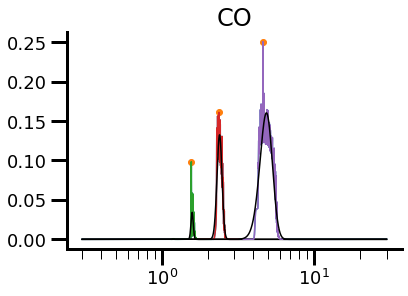

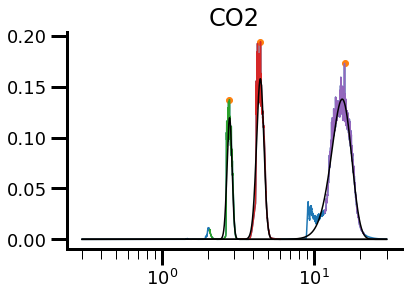

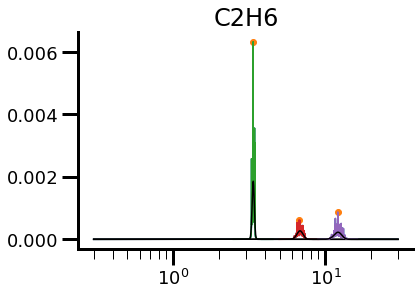

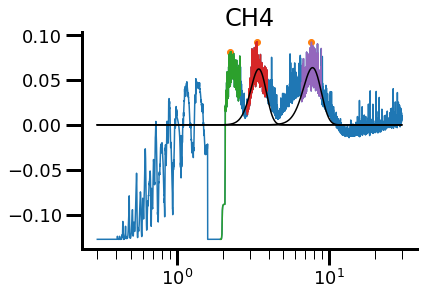

In [7]:
species = ['CO', 'CO2', 'C2H6', 'CH4']#, 'HCN']
slabels=['CO', 'CO$_2$', 'C$_2$H$_6$', 'CH$_4$']
distances = [250,250,250,400,250]
widths = [300,300,300,150]
peaks_b = []
for i,s in enumerate(species):
    out = find_species(s, distance=distances[i], width=widths[i])
    peaks_b.append(out)

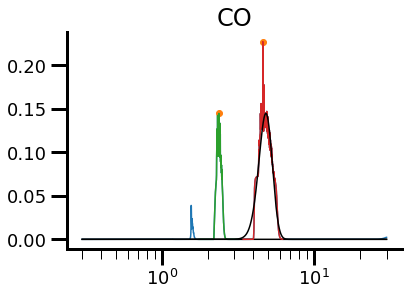

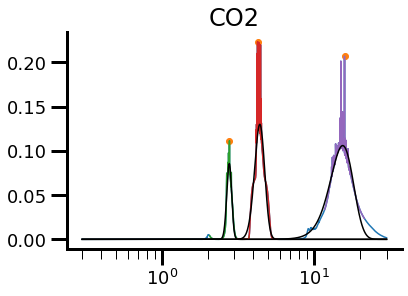

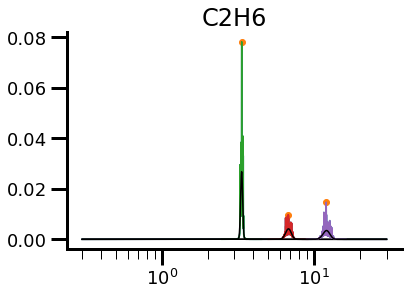

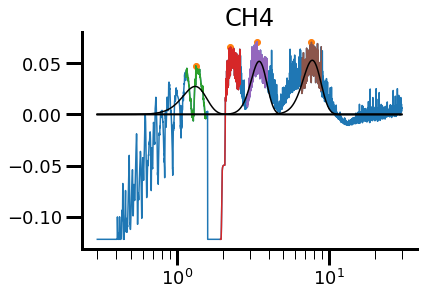

In [9]:
peaks_c = []
for i,s in enumerate(species):
    out = find_species(s, distance=distances[i], width=widths[i], planet='c', percentile=90)
    peaks_c.append(out)

## New Mock Up

/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_70124/2034593258.py:77: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/belugawhale/Documents/AUMic/paper/transmission.pdf', dpi=300,


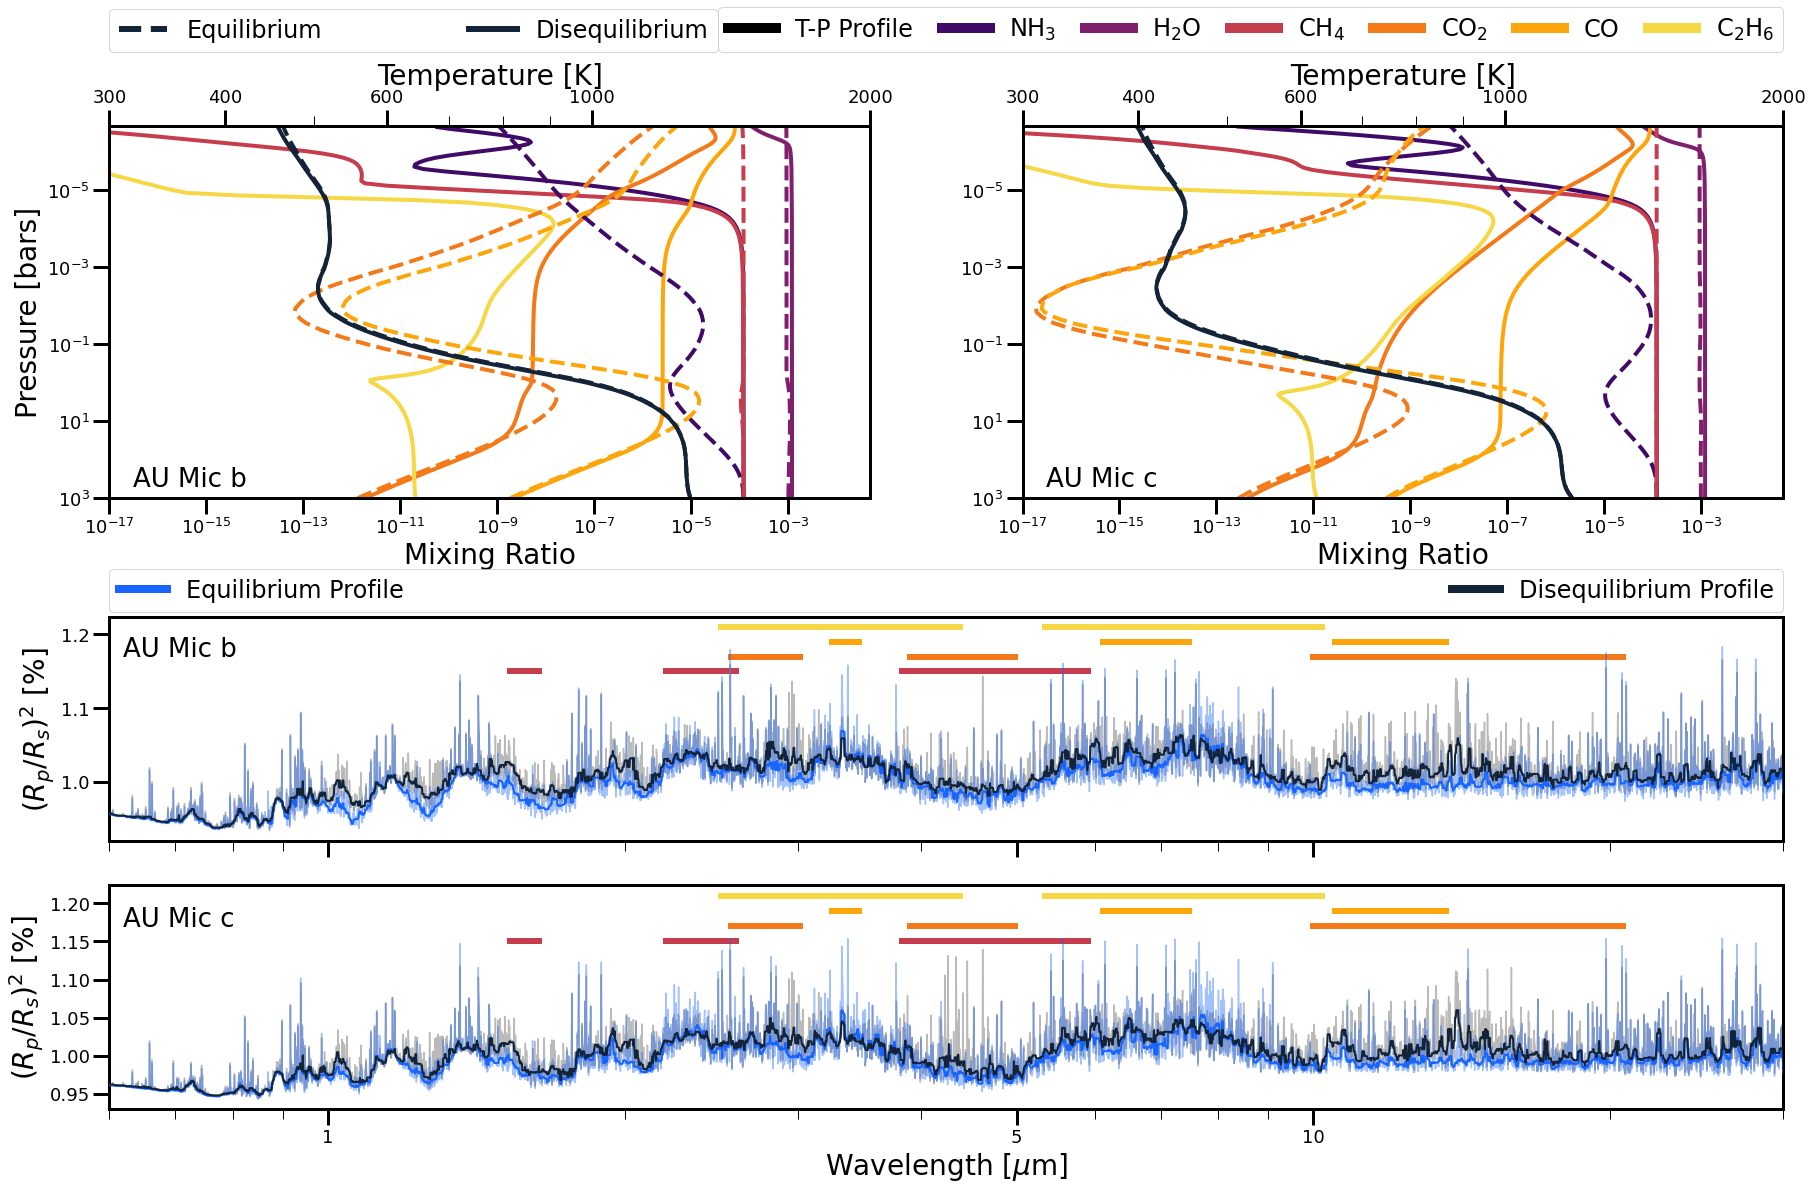

In [16]:
fig = plt.figure(figsize=(30,14))
gs_top = gridspec.GridSpec(3,2, top=1.1, height_ratios=[1.5,1,1])
gs_bottom = gridspec.GridSpec(3,2)

ax1 = fig.add_subplot(gs_top[0, 0])
ax3 = fig.add_subplot(gs_top[0, 1])
ax2 = fig.add_subplot(gs_bottom[1, :])
ax4 = fig.add_subplot(gs_bottom[2, :])


fig.set_facecolor('w')

sc = '#132338'
esc = '#1764ff'

ks=11

plot_spectrum(equil_spec_b, spec_b, ax2, label=True, ks=ks, lw=2)
plot_spectrum(equil_spec_c, spec_c, ax4, ks=ks, lw=2)

plot_hlines(ax2, peaks_b, colors=plot_colors[-4:])
plot_hlines(ax4, peaks_b, colors=plot_colors[-4:])

lgd = ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                 ncol=2, mode="expand", borderaxespad=0., fontsize=24)
for handle in lgd.legendHandles:
    handle.set_linewidth(8)

ax1.plot([1e4, 1e5], [1e4, 1e5], 'k', label='T-P Profile')
    
plot_table(tab_b, ax1, colors=plot_colors, label=True)
plot_table(tab_c, ax3, colors=plot_colors)

plot_table(equil_tab_b, ax1, colors=plot_colors, linestyle='--')
plot_table(equil_tab_c, ax3, colors=plot_colors, linestyle='--')

lgd = ax1.legend(bbox_to_anchor=(0.8, 1.2, 1.4, .102), loc=3,
                 ncol=7, mode="expand", borderaxespad=0., fontsize=24)
for handle in lgd.legendHandles:
    handle.set_linewidth(10)


tp_profile(equil_tab_b, tab_b, ax1, label=True, 
           lw=4)
tp_profile(equil_tab_c, tab_c, ax3, label=False,lw=4)

fs = 28
ax1.set_xlabel('Mixing Ratio', fontsize=fs)    
ax3.set_xlabel('Mixing Ratio', fontsize=fs)
ax4.set_xlabel('Wavelength [$\mu$m]', fontsize=fs)
ax1.set_ylabel('Pressure [bars]', fontsize=fs)
ax4.set_ylabel('($R_p/R_s)^2$ [%]', fontsize=fs)
ax2.set_ylabel('($R_p/R_s)^2$ [%]', fontsize=fs)

for i, ax in enumerate([ax2, ax4]):
    ax.set_xscale('log')
    ax.set_xlim(0.6,30)
    xticks = [1,5,10]
    ax.set_xticks(xticks)
    if i == 0:
        ax.set_xticklabels([])
    else:   
        ax.set_xticklabels(xticks)

for ax in [ax1, ax3]:
    ax.set_xlim(1e-17, 0.05)
    ax.set_ylim(1000, 2.2e-7)
    ax.set_xscale('log')
    ax.set_yscale('log')

ax1.text(s='AU Mic b', x=3e-17, y=5e2, fontsize=26)
ax3.text(s='AU Mic c', x=3e-17, y=5e2, fontsize=26)

ax2.text(s='AU Mic b', x=0.62, y=1.17, fontsize=26)
ax4.text(s='AU Mic c', x=0.62, y=1.17, fontsize=26)

plt.savefig('/Users/belugawhale/Documents/AUMic/paper/transmission.pdf', dpi=300,
            rasterize=True, bbox_inches='tight')

In [17]:
from lightkurve.lightcurve import LightCurve

In [18]:
lk = LightCurve((spec_b[:,0]*units.m).to(units.micron).value, spec_b[:,1])

/Users/belugawhale/opt/anaconda3/lib/python3.9/site-packages/lightkurve/lightcurve.py:160: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(


In [19]:
lkb = lk.bin(time_bin_size=0.1)

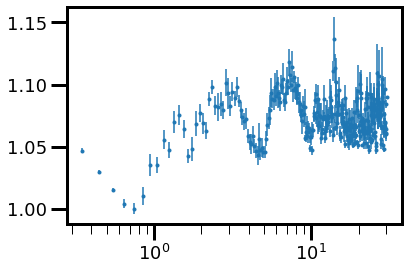

In [20]:
plt.errorbar(lkb.time.value, lkb.flux.value/np.nanmin(lkb.flux.value),
             yerr=lkb.flux_err.value, marker='.', linestyle='')
plt.xscale('log')

In [45]:
def bin_spec(tab):
    bins = np.flip(np.logspace(np.log10(30),np.log10(0.5), 250))
    x = (tab[:,0]*units.m).to(units.micron).value
    y = tab[:,1]/np.nanmedian(tab[:,1][:100])

    new = []
    for i in range(len(bins)):
        try:
            q = (x>bins[i]) & (x<=bins[i+1])
        except:
            q = (x>bins[i]) 
        new.append([np.nanmedian(y[q]), np.nanstd(y[q])])  
        
    new = np.array(new)
    newx =  bins#np.append((bins[:1]+bins[1:])/2, np.nanmedian(x[q]))
    return newx, new

In [46]:
def plot_spectrum_talk(equil, disequil, ax, label=False, alpha=0.3, ks=31, lw=3, 
                       ceq=esc, cdis=sc, binsize=0.1):
    
    eq_binx, eq_biny = bin_spec(equil)
    eq_biny[:,0] /= np.nanmin(eq_biny[:,0])

    ax.plot(eq_binx, eq_biny[:,0],
                 lw=3,
                c=ceq,  zorder=3)
    
    ax.fill_between(eq_binx, 
                    eq_biny[:,0]-eq_biny[:,1], eq_biny[:,0]+eq_biny[:,1],
                    alpha=0.4, lw=0, color=ceq, zorder=1)
    
    if cdis=='k':
        falpha=alpha-0.1
    else:
        falpha=alpha

    ds_binx, ds_biny = bin_spec(disequil)
    ds_biny[:,0] /= np.nanmin(ds_biny[:,0])
    
    ax.plot(ds_binx, ds_biny[:,0],
                lw=3,
                c=cdis, zorder=3)
    ax.fill_between(ds_binx, 
                    ds_biny[:,0]-ds_biny[:,1], ds_biny[:,0]+ds_biny[:,1],
                    alpha=falpha, lw=0, color=cdis, zorder=1)

In [55]:

COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 16 #12
plt.rcParams['ytick.major.size']  = 16 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 10
plt.rcParams['ytick.minor.size']  = 10

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'


sc = '#132338'
esc = '#1764ff'

/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_70124/3418380575.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/belugawhale/Documents/GitHub/presentation-figures/aumic-flares/light-bkg/au_mic_b_trans.png',


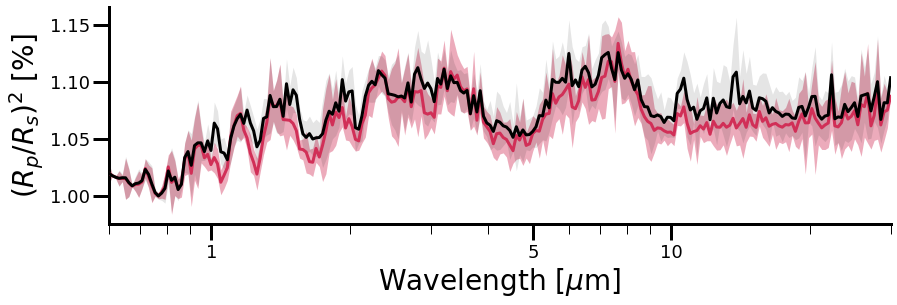

In [56]:
fig, ax = plt.subplots(figsize=(14,4))
plot_spectrum_talk(equil_spec_b, spec_b, ax, label=True, ks=ks, lw=2,
                   alpha=0.2, cdis=COLOR, ceq='#d12f57')
plt.xscale('log')
ax.set_xlabel('Wavelength [$\mu$m]', fontsize=fs)
ax.set_ylabel('($R_p/R_s)^2$ [%]', fontsize=fs)
ax.set_xlim(0.6,30)
ax.set_xticks([1, 5, 10])
ax.set_xticklabels([1, 5, 10])
plt.savefig('/Users/belugawhale/Documents/GitHub/presentation-figures/aumic-flares/light-bkg/au_mic_b_trans.png', 
            dpi=300,
            rasterize=True, bbox_inches='tight', transparent=True)

No handles with labels found to put in legend.


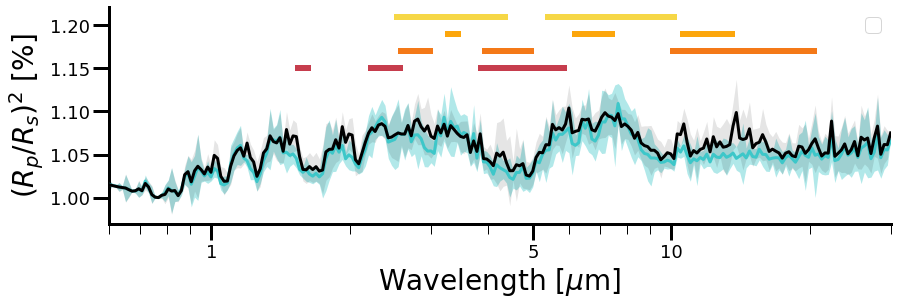

In [62]:
fig, ax = plt.subplots(figsize=(14,4))
plot_spectrum_talk(equil_spec_c, spec_c, ax, label=True, ks=ks, lw=2, alpha=0.2,
              cdis=COLOR, ceq='#3dc7c9')
plt.xscale('log')

ax.set_xlabel('Wavelength [$\mu$m]', fontsize=fs)
ax.set_ylabel('($R_p/R_s)^2$ [%]', fontsize=fs)
ax.set_xlim(0.6,30)
ax.set_xticks([1, 5, 10])
ax.set_xticklabels([1, 5, 10])
plot_hlines(ax, peaks_b, colors=plot_colors[-4:])
#plt.savefig('/Users/belugawhale/Desktop/test.png',
            
#            rasterize=True, bbox_inches='tight', transparent=True)

In [58]:
peaks_b

[array([[1.51862751, 1.64683688],
        [2.18505178, 2.60995399],
        [3.79711883, 5.94672673]]),
 array([[ 2.54582265,  3.03440583],
        [ 3.86696305,  5.01962494],
        [ 9.91700728, 20.75201868]]),
 array([[ 3.22078953,  3.48407658],
        [ 6.07797385,  7.53845995],
        [10.45054778, 13.74526931]]),
 array([[ 5.88682366,  5.88682366],
        [ 2.48920873,  4.41185691],
        [ 5.30048593, 10.26896522]])]